In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words=[]
with open('names.txt', 'r') as file:
    words=file.read().splitlines()

In [3]:
len(words)

32033

In [4]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s, i in stoi.items()}

In [5]:
block_size=5 #how many character to use to predict next one
def build_dataset(words):
    
    X,Y=[],[]
    for w in words:
        #print(w)
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [6]:
embedding_dim=20
hidden_layer_neurons=180

g=torch.Generator().manual_seed(2147483647)
C=torch.randn((27,embedding_dim), generator = g)
W1=torch.randn((block_size*embedding_dim, hidden_layer_neurons), generator = g)
b1=torch.randn(hidden_layer_neurons, generator = g)
W2=torch.randn((hidden_layer_neurons,27), generator = g)
b2=torch.randn(27, generator = g)
parameters=[C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [7]:
sum(p.nelement() for p in parameters)

23607

In [8]:
lre=torch.linspace(-3,0,1000)
lrs=10**lre

In [9]:
lri=[]
lossi=[]
stepi=[]

In [10]:
batch_size=32
max_steps=300000
for i in range(max_steps):
    #mini-batch
    ix=torch.randint(0,Xtr.shape[0],(batch_size,))
    
    #forward pass
    emb= C[Xtr[ix]]
    h=torch.tanh(emb.view(-1,block_size*embedding_dim) @ W1 + b1)
    logits = h @ W2 + b2
    #counts = torch.exp(logits)
    #prob = counts / counts.sum(1, keepdims=True)
    #loss=-prob[torch.arange(32), Y].log().mean()
    loss=F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    
    #update
    #lr = lrs[i]
    lr=0.1
    if i>int(max_steps/3):
        lr=0.02
    if i>int(max_steps/3*2):
        lr=0.004
    for p in parameters:
        p.data += -lr * p.grad

    #track
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
        
print(loss.item())

2.1436269283294678


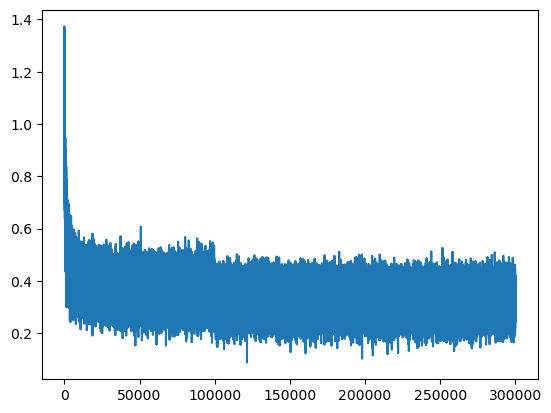

In [11]:
plt.plot(stepi,lossi)

In [12]:
emb= C[Xdev]
h=torch.tanh(emb.view(-1,block_size*embedding_dim) @ W1 + b1)
logits = h @ W2 + b2
loss=F.cross_entropy(logits, Ydev)
loss.item()

2.206448554992676

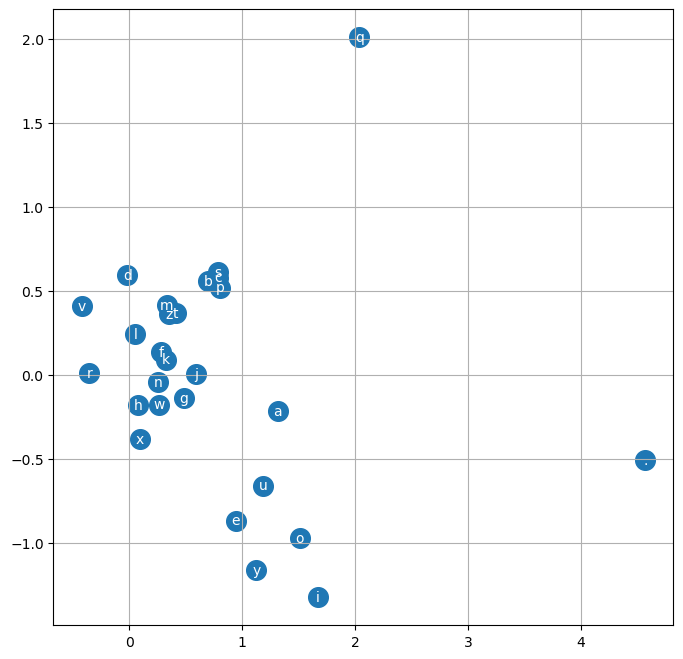

In [13]:
#makes sence only when embedding_dim==2
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(),itos[i],ha="center",va="center", color="white")
plt.grid('minor')

In [16]:
for i in range(5):

    out=[]
    context =[0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h=torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = torch.softmax(logits, dim=1)
        print(probs)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context=context[1:]+[ix]
        if ix == 0:
            break
        else:
            out.append(ix)

    print(''.join(itos[i] for i in out))

tensor([[9.0519e-06, 1.3643e-01, 3.6115e-02, 4.1822e-02, 5.4431e-02, 4.9713e-02,
         1.1107e-02, 2.6511e-02, 2.6357e-02, 2.1239e-02, 8.7758e-02, 1.0214e-01,
         4.7471e-02, 7.1390e-02, 3.7932e-02, 1.3118e-02, 1.3980e-02, 2.6052e-03,
         4.7148e-02, 6.8731e-02, 3.1222e-02, 2.4875e-03, 1.1352e-02, 9.8222e-03,
         4.4324e-03, 1.7847e-02, 2.6830e-02]], grad_fn=<SoftmaxBackward0>)
tensor([[1.8751e-07, 4.8084e-01, 1.2550e-04, 1.0368e-03, 8.2935e-04, 1.6871e-01,
         9.4892e-06, 9.8172e-05, 1.3091e-02, 1.1571e-01, 4.9954e-04, 2.0708e-04,
         2.0151e-03, 1.1478e-03, 4.9107e-04, 1.2051e-01, 1.7091e-04, 6.4907e-06,
         1.2526e-02, 1.0975e-03, 6.4569e-04, 3.6296e-02, 1.8022e-04, 1.0315e-03,
         9.4487e-06, 4.2196e-02, 5.2331e-04]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0022, 0.0176, 0.0167, 0.0234, 0.0347, 0.0315, 0.0060, 0.0101, 0.0359,
         0.0812, 0.0069, 0.0305, 0.0932, 0.0606, 0.1187, 0.0097, 0.0046, 0.0031,
         0.1217, 0.0656, 0.0276, 0.0103,